In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

In [3]:
results = pd.DataFrame()

# Load C14 models

In [4]:
import c14_models

In [5]:
import importlib
importlib.reload(c14_models)

<module 'c14_models' from '/home/fabrost/work/C14_liver/c14_models.py'>

# Read patient data

In [6]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C']]
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C']
c14_patient_data['mass'] = 1.0
c14_patient_data['d14C'] /= 1000.0

In [7]:
hepatocyte_data = c14_patient_data.query('type == "hepatocyte"')
hepatocyte_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


# SSE & log-likelihood

In [8]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [9]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [10]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [20]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1(Dbirth, Dcoll, lam)[1]

## Artifical data

In [21]:
lam = 0.1
n = 20
np.random.seed(42)
artifical_data = pd.DataFrame(
                    data={'Dbirth': 
                               np.random.uniform(1930, 1970, n), 
                          'Dcoll': 
                               np.random.uniform(2014, 2018, n)}
                             )

artifical_data['d14C'] = I1(artifical_data['Dbirth'], 
                            artifical_data['Dcoll'], 
                            loglam=np.log(lam)) 
artifical_data['d14C'] += np.random.normal(0, 0.01, 
                                           len(artifical_data)
                                          )

In [22]:
artifical_data.head()

,Dbirth,Dcoll,d14C
0,1944.981605,2016.447412,0.068673
1,1968.028572,2014.557975,0.072390
2,1959.279758,2015.168579,0.084830
3,1953.946339,2015.465447,0.062217
4,1936.240746,2015.824280,0.074492


## Parameter recovery

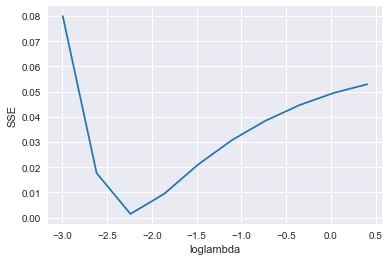

In [23]:
xx = np.linspace(np.log(0.05), np.log(1.5), 10)
yy = [SSE([loglam], I1, artifical_data) for loglam in xx]
plt.plot(xx, yy)

plt.xlabel('loglambda')
plt.ylabel('SSE')

plt.show()

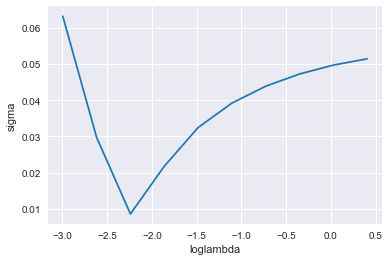

In [27]:
xx = np.linspace(np.log(0.05), np.log(1.5), 10)
yy = [Sigma([loglam], I1, artifical_data) for loglam in xx]
plt.plot(xx, yy)

plt.xlabel('loglambda')
plt.ylabel('sigma')

plt.show()

In [32]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, artifical_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

/home/fabrost/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  max(1, SAFETY * error_norm ** (-1 / (order + 1))))


In [36]:
lam = sp.exp(res[0])
print('lamda', lam)

sig = Sigma([np.log(lam)], I1, artifical_data)
print('sigma', sig)

lamda 0.1
sigma 0.00926419903019


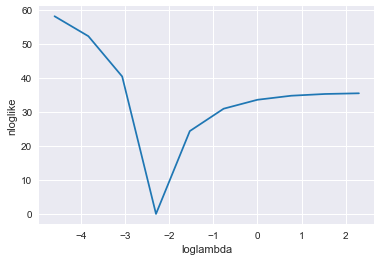

In [37]:
plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

### Plot

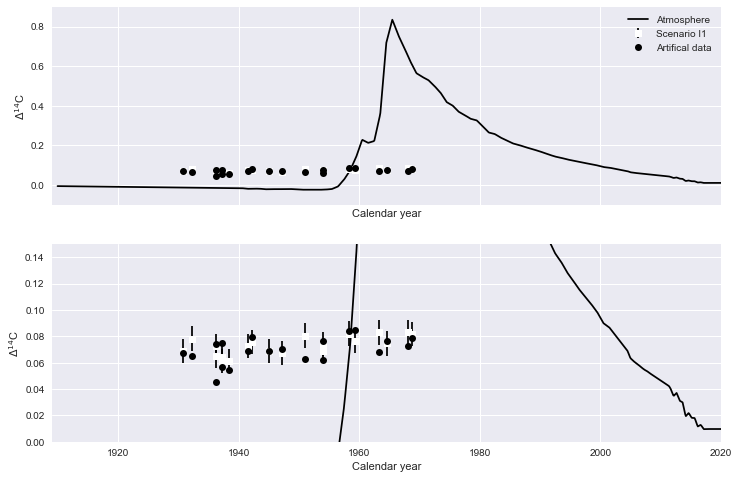

In [40]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (12, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, np.vectorize(c14_models.C_atm)(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(artifical_data['Dbirth'], \
                I1(artifical_data['Dbirth'], 
                   artifical_data['Dcoll'], 
                   np.log(lam)), 
                sig,
                color = 'white', ecolor = 'black', 
                marker='s', ls = '',
                label = 'Scenario I1')


    ax.errorbar(artifical_data['Dbirth'], 
                artifical_data['d14C'], 
                marker = 'o', ls = 'None', color = 'black',
                label = 'Artifical data')
#     ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
#                marker = 'o', ls = 'None', color = 'red', 
#                label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('plots/c14_predict_L1.png', bbox_inches='tight', dpi=300)

plt.show()

## Fit

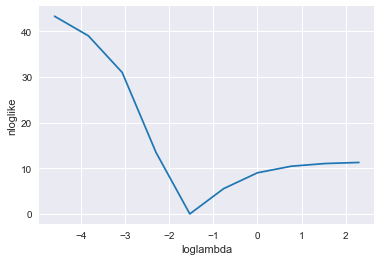

In [143]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, hepatocyte_data,),
                  Ns = 10,
                  full_output = True,
                  finish=None)

plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

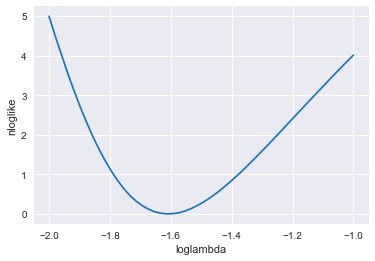

In [162]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, -1)],
                  args = (I1, hepatocyte_data,),
                  Ns = 50,
                  full_output = True,
                  finish=None)

plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

In [163]:
lam = sp.exp(res[0])
print('lamda', lam)

sig = Sigma([np.log(lam)], I1, hepatocyte_data)
print('sigma', sig)

results.loc['I1', 'loglike'] = -res[1]
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(hepatocyte_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.199439390075
sigma 0.0168037046849


,loglike,n,k,cAIC
I1,50.677130,19.0,2.0,-96.604260
I2,50.665708,19.0,3.0,-93.731416


In [ ]:
Sigma([np.log(lam)], I1, artifical_data)

### Plot

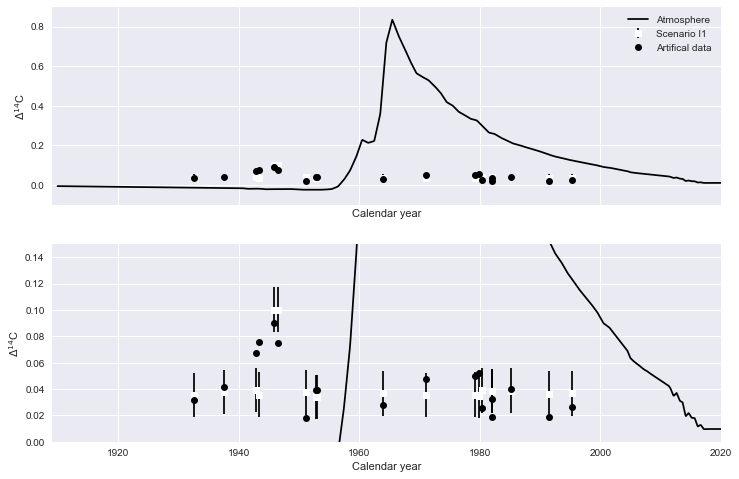

In [47]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (12, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, np.vectorize(c14_models.C_atm)(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(hepatocyte_data['Dbirth'], \
                I1(hepatocyte_data['Dbirth'], 
                   hepatocyte_data['Dcoll'], 
                   np.log(lam)), 
                sig,
                color = 'white', ecolor = 'black', 
                marker='s', ls = '',
                label = 'Scenario I1')


    ax.errorbar(hepatocyte_data['Dbirth'], 
                hepatocyte_data['d14C'], 
                marker = 'o', ls = 'None', color = 'black',
                label = 'Artifical data')
#     ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
#                marker = 'o', ls = 'None', color = 'red', 
#                label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('plots/c14_predict_L1.png', bbox_inches='tight', dpi=300)

plt.show()

# IL

In [52]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [59]:
IL(1930, 2015, np.log(0.01), 1.0)

/home/fabrost/work/C14_liver/c14_models.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  d_cB = lam * f / (1-f) * (cA - cB)
/home/fabrost/work/C14_liver/c14_models.py:149: RuntimeWarning: invalid value encountered in double_scalars
  d_cB = lam * f / (1-f) * (cA - cB)


array(nan)

In [71]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.1), np.log(100.0)), (0.01, 0.99)],
                  args = (IL, hepatocyte_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

In [72]:
res[0]

array([-1.57545296,  0.83526316])

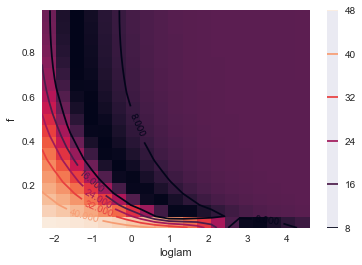

In [73]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

plt.pcolormesh(x, y, z)

CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

# I2

In [59]:
@np.vectorize
def I2(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.I2(Dbirth, Dcoll, lam, f)[1]

## Artifical data

In [60]:
lam = 0.1
f = 0.5
n = 20
np.random.seed(42)
artifical_data = pd.DataFrame(
                    data={'Dbirth': 
                               np.random.uniform(1930, 1970, n), 
                          'Dcoll': 
                               np.random.uniform(2014, 2018, n)}
                             )

artifical_data['d14C'] = I2(artifical_data['Dbirth'], 
                            artifical_data['Dcoll'], 
                            loglam=np.log(lam), 
                            f=f) 
artifical_data['d14C'] += np.random.normal(0, 0.01, 
                                           len(artifical_data)
                                          )

In [61]:
artifical_data.head()

,Dbirth,Dcoll,d14C
0,1944.981605,2016.447412,0.023212
1,1968.028572,2014.557975,0.358806
2,1959.279758,2015.168579,0.109228
3,1953.946339,2015.465447,0.012777
4,1936.240746,2015.824280,0.030668


## Parameter recovery

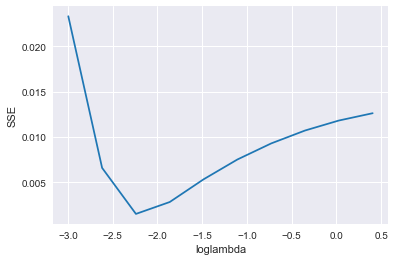

In [65]:
xx = np.linspace(np.log(0.05), np.log(1.5), 10)
yy = [SSE([loglam, 0.5], I2, artifical_data) for loglam in xx]
plt.plot(xx, yy)

plt.xlabel('loglambda')
plt.ylabel('SSE')

plt.show()

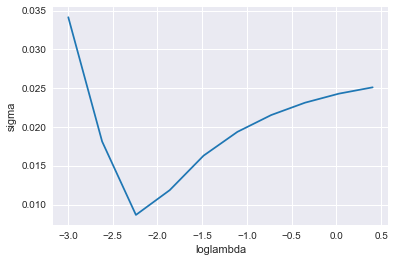

In [66]:
xx = np.linspace(np.log(0.05), np.log(1.5), 10)
yy = [Sigma([loglam, 0.5], I2, artifical_data) for loglam in xx]
plt.plot(xx, yy)

plt.xlabel('loglambda')
plt.ylabel('sigma')

plt.show()

In [91]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0)), (0, 1)],
                  args = (I2, artifical_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

/home/fabrost/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  max(1, SAFETY * error_norm ** (-1 / (order + 1))))


In [92]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, artifical_data)
print('sigma', sig)

lamda 0.1
f 0.555555555556
sigma 0.0157193319169


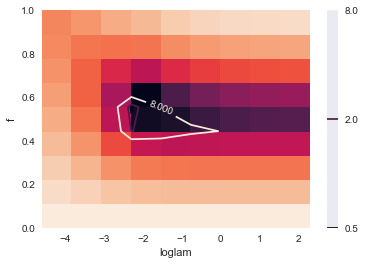

In [105]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

plt.pcolormesh(x, y, z)

CS = plt.contour(x, y, z, levels = [0.5, 2.0, 8.0])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [109]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2.5, -1.5), (0.4, 0.6)],
                  args = (I2, artifical_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

In [110]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, artifical_data)
print('sigma', sig)

lamda 0.114558843993
f 0.488888888889
sigma 0.00900473856192


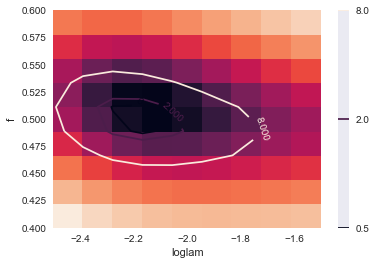

In [111]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

plt.pcolormesh(x, y, z)

CS = plt.contour(x, y, z, levels = [0.5, 2.0, 8.0])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

### Plot

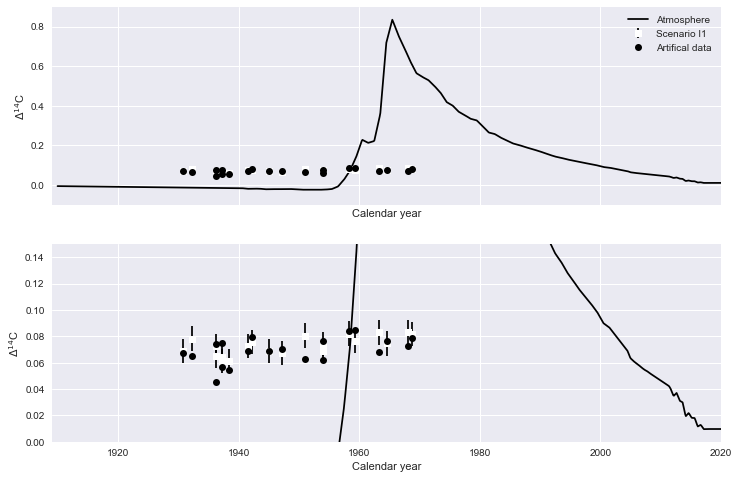

In [40]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (12, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, np.vectorize(c14_models.C_atm)(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(artifical_data['Dbirth'], \
                I1(artifical_data['Dbirth'], 
                   artifical_data['Dcoll'], 
                   np.log(lam)), 
                sig,
                color = 'white', ecolor = 'black', 
                marker='s', ls = '',
                label = 'Scenario I1')


    ax.errorbar(artifical_data['Dbirth'], 
                artifical_data['d14C'], 
                marker = 'o', ls = 'None', color = 'black',
                label = 'Artifical data')
#     ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
#                marker = 'o', ls = 'None', color = 'red', 
#                label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('plots/c14_predict_L1.png', bbox_inches='tight', dpi=300)

plt.show()

## Fit

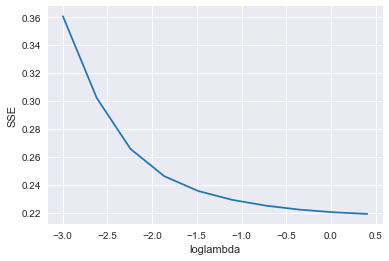

In [112]:
xx = np.linspace(np.log(0.05), np.log(1.5), 10)
yy = [SSE([loglam, 0.5], I2, hepatocyte_data) for loglam in xx]
plt.plot(xx, yy)

plt.xlabel('loglambda')
plt.ylabel('SSE')

plt.show()

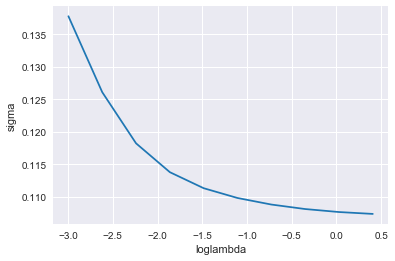

In [113]:
xx = np.linspace(np.log(0.05), np.log(1.5), 10)
yy = [Sigma([loglam, 0.5], I2, hepatocyte_data) for loglam in xx]
plt.plot(xx, yy)

plt.xlabel('loglambda')
plt.ylabel('sigma')

plt.show()

In [118]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(100.0)), (0, 1)],
                  args = (I2, hepatocyte_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

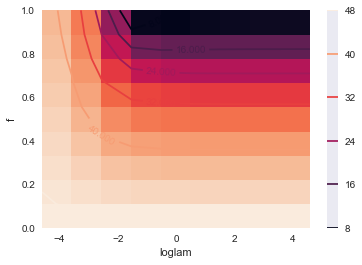

In [121]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

plt.pcolormesh(x, y, z)

CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

lamda 0.188875602838
f 1.0
sigma 0.131376419336


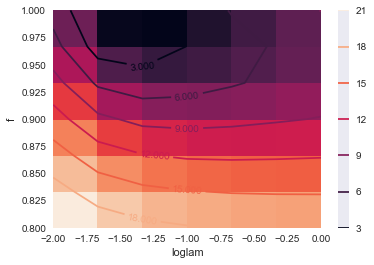

In [122]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, 0), (0.8, 1)],
                  args = (I2, hepatocyte_data),
                  Ns = 7,
                  full_output = True,
                  finish=None)

plt.pcolormesh(x, y, z)

CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

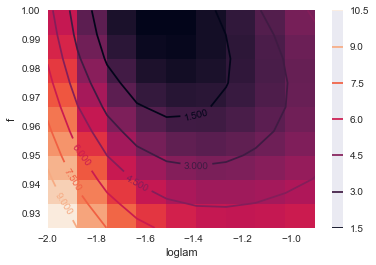

In [149]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, -0.9), (0.925, 1)],
                  args = (I2, hepatocyte_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

plt.pcolormesh(x, y, z)

CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

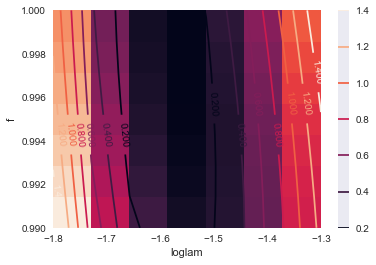

In [168]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-1.8, -1.3), (0.99, 1)],
                  args = (I2, hepatocyte_data),
                  Ns = 8,
                  full_output = True,
                  finish=None)

x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

plt.pcolormesh(x, y, z)

CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [166]:
Sigma([np.log(lam)], I1, artifical_data)

0.1319333814361569

In [169]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, hepatocyte_data)
print('sigma', sig)

results.loc['I2', 'loglike'] = -res[1]
results.loc['I2', 'k'] = 3
results.loc['I2', 'n'] = len(hepatocyte_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.204801454106
f 0.997142857143
sigma 0.0168021673604


,loglike,n,k,cAIC
I1,50.677130,19.0,2.0,-96.604260
I2,50.678868,19.0,3.0,-93.757737


### Plot

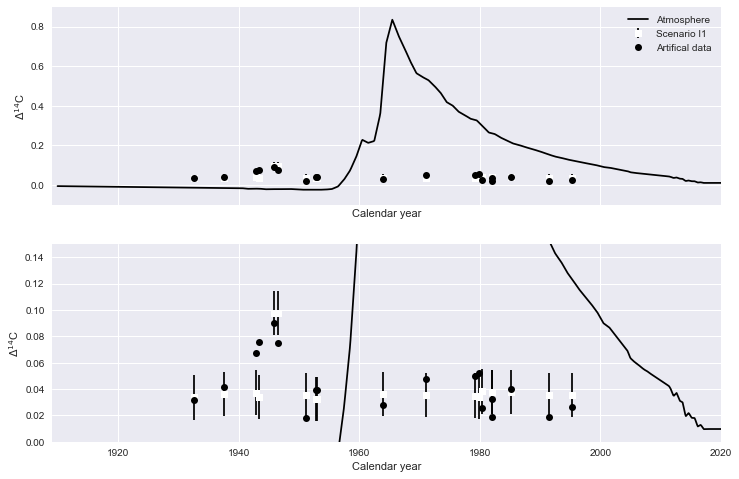

In [170]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (12, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, np.vectorize(c14_models.C_atm)(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(hepatocyte_data['Dbirth'], \
                I2(hepatocyte_data['Dbirth'], 
                   hepatocyte_data['Dcoll'], 
                   np.log(lam), f), 
                sig,
                color = 'white', ecolor = 'black', 
                marker='s', ls = '',
                label = 'Scenario I1')


    ax.errorbar(hepatocyte_data['Dbirth'], 
                hepatocyte_data['d14C'], 
                marker = 'o', ls = 'None', color = 'black',
                label = 'Artifical data')
#     ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
#                marker = 'o', ls = 'None', color = 'red', 
#                label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('plots/c14_predict_L1.png', bbox_inches='tight', dpi=300)

plt.show()

# Scenario IX2p

In [330]:
@np.vectorize
def IX2p(Dbirth, Dcoll, dloglam1, dloglam2, f1):
    dlam1 = np.exp(dloglam1)
    dlam2 = np.exp(dloglam2)
    
    f2 = 1-f1
    
    return c14_models.IX(Dbirth, Dcoll, [dlam1, dlam2], [f1, f2])[1]

In [332]:
IX2p(1930, 2015, np.log(0.1), np.log(0.1), 0.9)

array([ 0.07494134])

## Fit

In [349]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(5.0)),(np.log(0.01), np.log(5.0)) , (0, 1)],
                  args = (IX2p, hepatocyte_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

In [350]:
res

(array([-3.22414616, -1.15261013,  0.11111111]),
 -51.874111715291804,
 array([[[[-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          ..., 
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019]],
 
         [[-3.91465818, -3.91465818, -3.91465818, ..., -3.91465818,
           -3.91465818, -3.91465818],
          [-3.91465818, -3.91465818, -3.91465818, ..., -3.91465818,
           -3.91465818, -3.91465818],
          [-3.91465818, -3.91465818, -3.91465818, ..., -3.9146

In [351]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(2.0)),(np.log(0.01), np.log(2.0)) , (0, 1)],
                  args = (IX2p, hepatocyte_data),
                  Ns = 15,
                  full_output = True,
                  finish=None)

In [352]:
res

(array([-3.09136522,  0.69314718,  0.21428571]),
 -51.855414723956841,
 array([[[[-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          ..., 
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019],
          [-4.60517019, -4.60517019, -4.60517019, ..., -4.60517019,
           -4.60517019, -4.60517019]],
 
         [[-4.22671895, -4.22671895, -4.22671895, ..., -4.22671895,
           -4.22671895, -4.22671895],
          [-4.22671895, -4.22671895, -4.22671895, ..., -4.22671895,
           -4.22671895, -4.22671895],
          [-4.22671895, -4.22671895, -4.22671895, ..., -4.2267

In [353]:
results.loc['IX2p', 'loglike'] = -res[1]
results.loc['IX2p', 'k'] = 3
results.loc['IX2p', 'n'] = len(hepatocyte_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

,loglike,n,k,cAIC
I1,50.677130,19.0,2.0,-96.604260
I2,50.678868,19.0,3.0,-93.757737
R1,50.678868,19.0,2.0,-96.607737
IX2p,51.855415,19.0,3.0,-96.110829


# Scenario A = R1

In [191]:
K = np.vectorize(c14_models.C_atm)
C = c14_models.C_scenario_A

## Fit

In [193]:
sigma_estimate = hepatocyte_data['d14C'].std()

In [194]:
def neg_loglike_A(logr, sigma):
    r = np.exp(logr)
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [195]:
M_A = iminuit.Minuit(neg_loglike_A, errordef = 0.5,\
           logr = np.log(0.0066), error_logr = np.log(1e-3), fix_logr = False,\
           sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
           print_level = 1)
M_A.migrad();

FCN = -50.673533256316475 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = 1.722160944637842e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,logr,-1.60825,0.115856,0,0,,,
2,sigma,0.0167915,0.00272054,0,0,0.0,,


In [197]:
np.exp(M_A.values['logr'])

{'logr': -1.608253538994529, 'sigma': 0.016791538366454306}

In [198]:
lam = np.exp(M_A.values['logr'])
print('lamda', lam)

sig = M_A.values['sigma']
print('sigma', sig)

results.loc['R1', 'loglike'] = -res[1]
results.loc['R1', 'k'] = 2
results.loc['R1', 'n'] = len(hepatocyte_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.200237015017
sigma 0.016791538366454306


,loglike,n,k,cAIC
I1,50.677130,19.0,2.0,-96.604260
I2,50.678868,19.0,3.0,-93.757737
R1,50.678868,19.0,2.0,-96.607737


### Plot

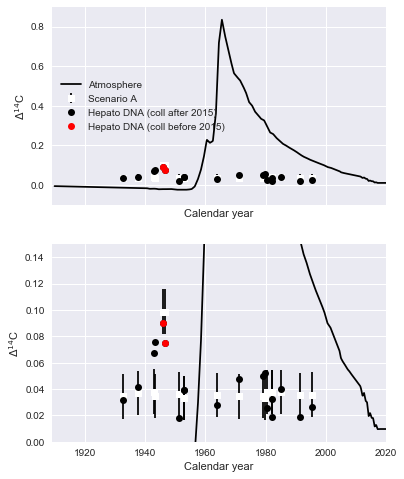

In [188]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (6, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, K(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(hepatocyte_data['Dbirth'], \
               sp.vectorize(C)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], np.exp(M_A.values['logr'])), M_A.values['sigma'],
               color = 'white', ecolor = 'black', label = 'Scenario A', marker='s', ls = '')


    ax.errorbar(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
            marker = 'o', ls = 'None', color = 'black',
               label = 'Hepato DNA (coll after 2015)')
    ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
               marker = 'o', ls = 'None', color = 'red', 
               label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)

plt.show()

In [ ]:
M_A.minos(sigma = 1.92);

In [ ]:
np.exp(CI(M_A, 'logr'))

In [ ]:
CI(M_A, 'sigma')

In [ ]:
M_A.draw_mnprofile('logr');

In [ ]:
M_A.draw_mnprofile('sigma');

# 2POP

### Sigma dependent on mass of sample

In [ ]:
def neg_loglike_A_mass(r, sigma_light, sigma_heavy):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        if dataset['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [ ]:
M_A_mass = iminuit.Minuit(neg_loglike_A_mass, errordef = 0.5,\
                          r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                          sigma_light = sigma_estimate, error_sigma_light = sigma_estimate / 10.0,
                          limit_sigma_light = (0.0, None), fix_sigma_light = False,
                          sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0,
                          limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,
                          print_level = 1)

In [ ]:
M_A_mass.migrad();

In [ ]:
def neg_loglike_2POP(r, f, sigma):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [ ]:
M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 1)

In [ ]:
M_2POP.migrad();

In [ ]:
f, ax = plt.subplots(1, 1, figsize = (6, 4))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
ax.errorbar(hepatocyte_data['Dbirth'], \
           sp.vectorize(C2)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.arange(1910, 2011, 10))
ax.set_xticks(sp.arange(1910, 2011, 2), minor = True)
ax.set_yticks(sp.arange(-0.1, 0.91, 0.1))
ax.set_yticks(sp.arange(-0.1, 0.91, 0.02), minor = True)
# ax.grid(which='both')
ax.legend(loc='best', numpoints = 1, scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel(u'Concentration of 14C (Δ14C)')

ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, ax.get_ylim()[0]), xytext = (1965, 0.05),
            arrowprops = dict(arrowstyle = '-|>', facecolor = 'white'))

axins = inset_axes(ax,
                   width="40%",  # width = 30% of parent_bbox
                   height=1.,  # height : 1 inch
                   loc=2, borderpad = 3)

axins.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
axins.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
axins.errorbar(hepatocyte_data['Dbirth'], \
           sp.vectorize(C2)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

axins.set_xlim(1941, 1959)
axins.set_ylim(-0.05, 0.09)
axins.set_xticks(sp.arange(1945, 1956, 5))
axins.set_xticks(sp.arange(1942, 1959, 1), minor=True)

axins.annotate("First above-ground\n thermonuclear bomb test", xy = (1952, axins.get_ylim()[0]), xytext = (1945.5, axins.get_ylim()[0] - 0.08),
            arrowprops = dict(arrowstyle = '-|>', facecolor = 'white'), horizontalalignment = 'left')

exportname = 'c14_predict_2POP'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

In [ ]:
matplotlib.text.Text?

In [ ]:
M_2POP.minos(sigma = 1.92);

In [ ]:
CI(M_2POP, 'f')

Calculate how much bigger Spalding's CI was:

In [ ]:
Delta_Rost = CI(M_2POP, 'f')[1] - CI(M_2POP, 'f')[0]
Delta_Spalding = 0.63 - 0.12
Delta_Spalding/Delta_Rost

In [ ]:
CI(M_2POP, 'sigma')

In [ ]:
M_2POP.draw_mnprofile('f');

In [ ]:
M_2POP.draw_mnprofile('sigma');

Manual profile likelihood for $r$ as `minos` didn't work.

In [ ]:
%%cache rprofile.pkl rs neglogL
rs = sp.sort(sp.hstack((sp.linspace(0.1, 10, 50), M_2POP.values['r'], 0.15)))
f_initial = M_2POP.values['f']
sigma_initial = M_2POP.values['sigma']
def fit_fix_r(r):
    M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = r, error_r = 1e-3, limit_r = (0.0, None), fix_r = True,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP.migrad()
    if M_2POP.migrad_ok():
        return M_2POP.fval
    else:
        return sp.nan

pool = Pool(processes=4) 

neglogL = sp.array(pool.map(fit_fix_r, rs))

In [ ]:
func = sp.interpolate.interp1d(rs, neglogL - neglogL.min() - 1.92) 

In [ ]:
from scipy import optimize
rmin = sp.optimize.root(func, 0.1, method='lm')['x'].item()
rmax = sp.optimize.root(func, 2, method='lm')['x'].item()

print('r:')
print('{0:.2f} (95\% CI [{1:.2f}, {2:.2f}])'.format(M_2POP.values['r'], rmin, rmax))


In [ ]:
fig = plt.figure(figsize= (150 / 25.4, 50 / 25.4) )
plt.xlim(0, 10)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

plt.plot(rs, -(neglogL-M_2POP.fval), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

exportname = 'rprofile'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

## 2POP mass

In [ ]:
def neg_loglike_2POP_mass(r, f, sigma_light, sigma_heavy):
    loglike = 0
    for i, row in hepatocyte_data.iterrows():
        Dbirth = row['Dbirth']
        Dcoll = row['Dcoll']
        Cexp = row['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        if row['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [ ]:
M_2POP_mass = iminuit.Minuit(neg_loglike_2POP_mass, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma_light = sigma_estimate*20, error_sigma_light = sigma_estimate / 10.0, limit_sigma_light = (0.0, None), fix_sigma_light = False,
                   sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0, limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,\
                   print_level = 1)

In [ ]:
M_2POP_mass.migrad();

## Sample size estimation
Here, I create simulated data from the model to estimate the sample size (needed number of additional subjects) to find a upper limit for $r$. In the model simulation I'll use the estimated point estimates of the parameters as true parameters. I use scenario 2POP.
### Simulate the model

In [ ]:
f_fit = M_2POP.values['f']
r_fit = M_2POP.values['r']
sigma_fit = M_2POP.values['sigma']

Let's first plot the model prediction for the expected difference in C-14 concentration when comparing the cases $r = r_{estimate}$ and $r = r_{max}$ and different birth and death times:

In [ ]:
time_min, time_max = 1910, 2015
sampling = 1
birth_times, death_times = sp.mgrid[time_min:time_max:sampling, time_min:time_max:sampling]
C14_diff = sp.absolute(sp.vectorize(C2)(birth_times, death_times, r_fit, f_fit) - sp.vectorize(C2)(birth_times, death_times, rmax, f_fit))
C14_diff = sp.ma.masked_array(C14_diff, mask = sp.isnan(C14_diff))

In [ ]:
%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(figsize = (3,2))
pcm = ax.pcolormesh(birth_times, death_times, C14_diff, cmap = 'viridis')
ax.set_xlabel('year of birth')
ax.set_ylabel('year of death', labelpad=10)
fig.colorbar(pcm)
ax.set_xlim(time_min, time_max)
ax.set_ylim(time_min, time_max)
ax.set_xticks(sp.arange(time_min, time_max, 20))
ax.set_xticks(sp.arange(time_min+10, time_max, 20), minor = True)
ax.set_yticks(sp.arange(time_min, time_max, 20))
ax.set_yticks(sp.arange(time_min+10, time_max, 20), minor = True)
# plt.contour(birth_times, death_times, C14_diff, [0.05], colors = 'red')

plt.show()

In [ ]:
max_index = sp.unravel_index(C14_diff.argmax(), C14_diff.shape)
death_times[max_index]

The biggest difference in C-14 is expected for subjects that died in 1965. 

### Creation of artifical subject data

#### Informative data

Based on the assumption that I my parameters are the true parameters I create artifical subject data by simulating the model. I'll choose subjects for which the expected difference in C-14 for the cases $r = r_{estimate}$ and $r = r_{max}$ is bigger than $0.05$.

In [ ]:
fig, ax = plt.subplots(figsize = (3,2))
pcm = ax.pcolormesh(birth_times, death_times, C14_diff > 0.05, cmap = 'Greys')
ax.set_xlabel('year of birth')
ax.set_ylabel('year of death')
fig.colorbar(pcm)
ax.set_xlim(time_min, time_max)
ax.set_ylim(time_min, time_max)

plt.show()

In [ ]:
chosen_birth_times = birth_times[C14_diff > 0.05]
chosen_death_times = death_times[C14_diff > 0.05]
chosen_times = zip(chosen_birth_times, chosen_death_times)

In [ ]:
%%cache profiles_r_2POP.pkl profile_r_2POP
profile_r_2POP = M_2POP.mnprofile('r', bound = [0.1, 1.5], subtract_min = True, bins = 60)

In [ ]:
%%cache profiles.pkl profiles test_datasets
n = 5
test_datasets = {}
profiles = {}
for i in range(5):
    sp.random.seed(i)
    
    indices = sp.random.choice(len(chosen_birth_times), n)
    
#     sampled_birth_times = chosen_birth_times[indices]
#     sampled_death_times = chosen_death_times[indices]

    sampled_birth_times = sp.random.uniform(1910, 1960, n)
    sampled_death_times = sp.random.uniform(1961, 1970, n)
    d14C = sp.vectorize(C2)(sampled_birth_times, sampled_death_times, r_fit, f_fit) + sp.random.normal(0, sigma_fit, len(sampled_birth_times))
    
    new_data = pd.DataFrame.from_dict({'Dbirth': sampled_birth_times, 'Dcoll': sampled_death_times, 'd14C': d14C})
    
    test_datasets[i] = pd.concat([hepatocyte_data, new_data], ignore_index=True)

for i, data in test_datasets.iteritems():
    def neg_loglike_2POP_test(r, f, sigma):
        loglike = 0
        for i, dataset in data.iterrows():
            Dbirth = dataset['Dbirth']
            Dcoll = dataset['Dcoll']
            Cexp = dataset['d14C']
            Cmodel = C2(Dbirth, Dcoll, r, f)

            loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
        return -loglike

    M_2POP_test = iminuit.Minuit(neg_loglike_2POP_test, errordef = 0.5,\
                   r = 0.2, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f= 0.3, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = 0.01, error_sigma = sigma_fit / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP_test.tol = 10.0
    M_2POP_test.migrad()
#     M_2POP_test.minos('r', sigma = 1.92)
    if M_2POP_test.migrad_ok():
        profiles[i] = M_2POP_test.mnprofile('r', bound = [0.1, 0.5], subtract_min = True, bins = 25);

Plot the artificial test data

In [ ]:
i = 1
artificial_data = test_datasets[i]

f, ax = plt.subplots(1, 1, figsize = (3, 2))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(artificial_data['Dbirth'], artificial_data['d14C'], color = colorcycle[i+1], label = 'Artificial data            ')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA                   ')
# ax.errorbar(artificial_data['Dbirth'], \
#            sp.vectorize(C2)(artificial_data['Dbirth'], artificial_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
#             M_2POP.values['sigma'],
#            color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best', scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

# ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
#             arrowprops = dict(arrowstyle = '-|>'))
# ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1967, 0.05),
#             arrowprops = dict(arrowstyle = '-|>'))


plt.show()

In [ ]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize= (75 / 25.4, 50 / 25.4) )
plt.xlim(0.1, 0.4)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

plt.plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

for i, profile in profiles.iteritems():
    plt.plot(profile[0], -sp.array(profile[1]), color = colorcycle[i+1])


plt.show()

#### 'Recent' data
Now, I repeat the creation of artificial data as above, but for patients that died in recent years. I choose 2012. I assume they are born bewteen 1910 and 2010 with uniform random distribution.

In [ ]:
len(hepatocyte_data)

In [ ]:
%%cache profiles_recent.pkl profiles_recent test_datasets_recent
n = 100
test_datasets_recent = {}
profiles_recent = {}
for i in sp.arange(5)+1:
    sp.random.seed(i)
    
    sampled_birth_times = sp.random.uniform(1910, 2010, n)
    sampled_death_times = 2012 * sp.ones(n)
    d14C = sp.vectorize(C2)(sampled_birth_times, sampled_death_times, r_fit, f_fit) + sp.random.normal(0, sigma_fit, len(sampled_birth_times))
    
    new_data = pd.DataFrame.from_dict({'Dbirth': sampled_birth_times, 'Dcoll': sampled_death_times, 'd14C': d14C})
    
    test_datasets_recent[i] = pd.concat([hepatocyte_data, new_data], ignore_index=True)

for i, data in test_datasets_recent.iteritems():
    def neg_loglike_2POP_test(r, f, sigma):
        loglike = 0
        for i, dataset in data.iterrows():
            Dbirth = dataset['Dbirth']
            Dcoll = dataset['Dcoll']
            Cexp = dataset['d14C']
            Cmodel = C2(Dbirth, Dcoll, r, f)

            loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
        return -loglike

    M_2POP_test = iminuit.Minuit(neg_loglike_2POP_test, errordef = 0.5,\
                   r = 0.2, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f= 0.3, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = 0.01, error_sigma = sigma_fit / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP_test.tol = 10.0
    M_2POP_test.migrad()
#     M_2POP_test.minos('r', sigma = 1.92)
    if M_2POP_test.migrad_ok():
        profiles_recent[i] = M_2POP_test.mnprofile('r', bound = [0.1, 1.5], subtract_min = True, bins = 60);

Plot the artificial test data

In [ ]:
i = 1
artificial_data_recent = test_datasets_recent[i]

f, ax = plt.subplots(1, 1, figsize = (3, 2))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(artificial_data_recent['Dbirth'], artificial_data_recent['d14C'], color = colorcycle[7], label = 'Artificial data            ')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA                   ')
# ax.errorbar(artificial_data_recent['Dbirth'], \
#            sp.vectorize(C2)(artificial_data_recent['Dbirth'], artificial_data_recent['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
#             M_2POP.values['sigma'],
#            color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best', scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

# ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
#             arrowprops = dict(arrowstyle = '-|>'))
# ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1967, 0.05),
#             arrowprops = dict(arrowstyle = '-|>'))

plt.show()

In [ ]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize= (75 / 25.4, 50 / 25.4) )
plt.xlim(0.1, 1.5)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

# plt.plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
plt.plot(rs, -(neglogL-M_2POP.fval), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

for i, profile in profiles_recent.iteritems():
    plt.plot(profile[0], -sp.array(profile[1]), color = colorcycle[i+1])

plt.show()

### Plot of artifial data results for thesis

In [ ]:
lineStyles = ['-', '--', '-.', ':']

new_artifical_data = artificial_data.loc[artificial_data.index.difference(hepatocyte_data.reset_index().index)]
new_artifical_data_recent = artificial_data_recent.loc[artificial_data_recent.index.difference(hepatocyte_data.reset_index().index)]

%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(2, 2, figsize = (160/25.4,4))

pcm = ax[0,0].pcolormesh(birth_times, death_times, C14_diff, cmap = 'viridis', shading = 'gourad')
ax[0,0].scatter(new_artifical_data_recent['Dbirth'].values, new_artifical_data_recent['Dcoll'].values,
                marker = '+', c = colorcycle[1])
ax[0,0].scatter(new_artifical_data['Dbirth'].values, new_artifical_data['Dcoll'].values,
                marker = '+', c = colorcycle[7])
ax[0,0].scatter(hepatocyte_data['Dbirth'].values, hepatocyte_data['Dcoll'].values, marker = '+', c = 'white')
ax[0,0].set_xlabel('Year of birth')
ax[0,0].set_ylabel('Year of death', labelpad=10)
cb = fig.colorbar(pcm, ax=ax[0,0])
cb.set_label(u'Difference in Δ14C', labelpad = 10)
ax[0,0].set_xlim(time_min, time_max)
ax[0,0].set_ylim(time_min, time_max)
ax[0,0].set_xticks(sp.arange(time_min, time_max, 20))
ax[0,0].set_xticks(sp.arange(time_min+10, time_max, 20), minor = True)
ax[0,0].set_yticks(sp.arange(time_min, time_max, 20))
ax[0,0].set_yticks(sp.arange(time_min+10, time_max, 20), minor = True)
# ax[0,0].add_patch(patches.Rectangle((1910, 2012), 100, 1, fill=False, color=colorcycle[1]))
# ax[0,0].add_patch(patches.Rectangle((1910, 1961), 50, 9, fill=False, color=colorcycle[2]))


artificial_data = test_datasets[1]
msize = 5
time = sp.linspace(1910.0, 2015.0, 1000)
ax[0,1].plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax[0,1].scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
                color = 'black', label = 'Neuronal DNA                        ', s = msize)
ax[0,1].scatter(new_artifical_data_recent['Dbirth'], new_artifical_data_recent['d14C'], 
                color = colorcycle[1], label = 'Artifical data 1', s = msize)
ax[0,1].scatter(new_artifical_data['Dbirth'], new_artifical_data['d14C'], 
                color = colorcycle[7], label = 'Artifical data 2     ', s = msize)


ax[0,1].set_xlim((1909, 2011))
ax[0,1].set_ylim(-0.1, 0.9)
ax[0,1].set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
ax[0,1].legend(loc='upper left', scatterpoints = 1)
ax[0,1].set_xlabel('Calendar year')
ax[0,1].set_ylabel(u'Δ14C')

ax[1,0].set_title('Artificial data 1', fontsize = 8)
ax[1,0].set_xlim(0.1, 1.5)
ax[1,0].set_ylim(-2.5, 0)
ax[1,0].set_xlabel('Turnover rate, r (per year)')
ax[1,0].set_ylabel(u'Δln L')
ax[1,0].plot(profile_r_2POP[0], -sp.array(profile_r_2POP[-1]), 'black')
# ax[1,0].plot(rs, -(neglogL-M_2POP.fval), 'black')
ax[1,0].plot([0, 10], [-1.92, -1.92], 'k--')
for i, profile in profiles_recent.iteritems():
    ax[1,0].plot(profile[0], -sp.array(profile[1]), color = colorcycle[1], ls = lineStyles[len(profile) - i])
    if i == len(lineStyles):
        break
    
ax[1,1].set_title('Artificial data 2', fontsize = 8)
ax[1,1].set_xlim(0.1, 1.5)
ax[1,1].set_ylim(-2.5, 0)
ax[1,1].set_xlabel('Turnover rate, r (per year)')
ax[1,1].set_ylabel(u'Δln L')
ax[1,1].plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
# ax[1,1].plot(rs, -(neglogL-M_2POP.fval), 'black')
ax[1,1].plot([0, 10], [-1.92, -1.92], 'k--')
for i, profile in profiles.iteritems():
    ax[1,1].plot(profile[0], -sp.array(profile[1]), color = colorcycle[7], ls = lineStyles[i-1])
    if i == len(lineStyles):
        break

plt.tight_layout()

exportname = 'c14_add_data'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))


plt.show()